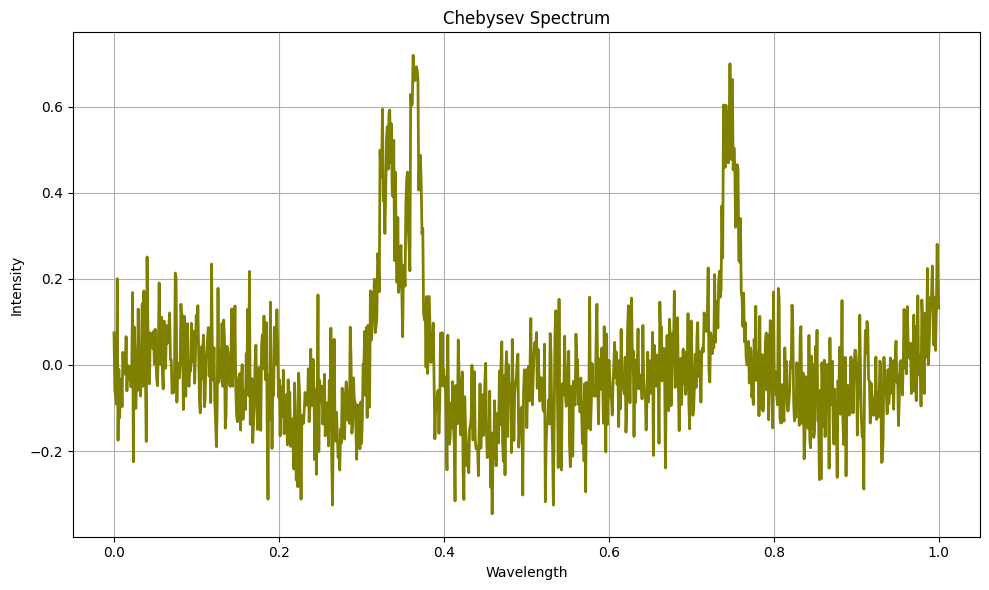

In [1]:
# 4. BASELINE VARIATION
# Baseline variation (iteration) & Polynomial order (random)
# Chebyshev polynomial baseline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from random import randint, uniform

class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(0, 1, self.pixels)
        self.spectrum = self.generate_spectrum()
        
    def generate_spectrum(self):
        # Generate baseline using a polynomial
        poly_order = np.random.randint(self.poly_order_range[0], self.poly_order_range[1] + 1)
        baseline_coefficients = np.random.rand(poly_order + 1)
        baseline = np.polyval(baseline_coefficients, self.wavelengths)
        
        # Generate Lorentzian peaks
        peaks = np.zeros_like(self.wavelengths)
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        for _ in range(num_peaks):
            peak_amplitude = np.random.uniform(0, 1)
            peak_position = np.random.uniform(0.2, 0.8)
            peak_width = 1 / (self.pixels * 0.1)
            peaks += peak_amplitude * (peak_width ** 2) / ((self.wavelengths - peak_position) ** 2 + peak_width ** 2)
        
        return baseline + peaks

    def add_gaussian_noise(self, noise_amplitude_range=(0.1, 0.5)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.spectrum) ** 2)
    
        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range
    
        # Calculate standard deviation of the noise
        noise_std = np.sqrt(noise_power)
        
        # Generate random noise amplitudes within the specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)
    
        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))
    
        # Scale the noise by the noise amplitudes
        noise *= noise_amplitudes
    
        # Add noise to signal
        noisy_spectrum = self.spectrum + noise
        
        return noisy_spectrum
    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(x))
        return chebyshev_vals

# Create an instance of SyntheticRamanSpectrum class
synthetic_spectrum = SyntheticRamanSpectrum(
    pixels=1024,
    poly_order_range=(2, 4),
    num_peaks_range=(2, 5),
    snr_range=10,  # Set your desired SNR here
    cosmic_ray_prob=0.1,
    num_spectra=1
)

# Get the synthetic spectrum and its parameters
wavelengths = synthetic_spectrum.wavelengths
original_spectrum = synthetic_spectrum.spectrum

# Add Gaussian noise to the synthetic spectrum
noisy_spectrum = synthetic_spectrum.add_gaussian_noise()

# Specify range for randomly selecting order of Chebyshev polynomial 
min_order = 2
max_order = 6

# Number of iterations (baseline segments)
num_iterations = 5

for _ in range(num_iterations):
    # Randomly select polynomial order (for iteration)
    order = randint(min_order, max_order)

    # Initial guess for Chebyshev polynomial coefficients (randomly initialized)
    initial_guess = [uniform(-1, 1) for _ in range(order)]

    # Fit Chebyshev polynomial to noisy data (for iteration)
    popt, _ = curve_fit(synthetic_spectrum.chebyshev_polynomial, wavelengths, noisy_spectrum, p0=initial_guess)

    # Generate baseline using fitted coefficients
    baseline = synthetic_spectrum.chebyshev_polynomial(wavelengths, *popt)

    # Correct noisy spectrum by subtracting baseline (for iteration)
    noisy_spectrum -= baseline

# Plot Chebysev Spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, noisy_spectrum, color='olive', label='Chebysev Spectrum', linewidth=2)
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Chebysev Spectrum')
plt.grid(True)
plt.tight_layout()
plt.show()